In [1]:
import platform
import sys
import os

os_name = platform.system()

if os_name == "Windows":
    module_path = r"Y:/git/regression_model_tuning/src/"
else:
    module_path = r"/gpfs/home1/r1jae262/jupyter/git/regression_model_tuning/src/"

sys.path.insert(0, module_path)


In [ ]:

from regression_model_tuning.data import Data


T = Data()
T.load_data(r"dataset/simulation_results.csv")
T.raw_data

In [ ]:
import platform
import sys
import os

os_name = platform.system()

if os_name == "Windows":
    module_path = r"Y:/git/regression_model_tuning/src/"
else:
    module_path = r"/gpfs/home1/r1jae262/jupyter/git/regression_model_tuning/src/"

sys.path.insert(0, module_path)

from regression_model_tuning import Trainer

data_path = r"dataset/simulation_results.csv"
input_cols = [
    "N1","N2","N1_layer","N2_layer","per",
    "w1","l1","l2","l2_gap","h1","h1_gap","h2_gap",
    "N1_height_ratio","N1_fill_factor","N1_coil_diameter","N1_coil_zgap","N2_height_ratio","N2_fill_factor","N2_coil_diameter","N2_coil_zgap",
    "N1_space_w","N1_space_l","N2_space_w","N2_space_l","N1_layer_gap","N2_layer_gap","N1_offset_ratio","N2_offset_ratio","N1_offset","N2_offset",
    "cold_plate_x","cold_plate_y","cold_plate_z1","cold_plate_z2","mold_thick","thermal_conductivity"]
output_cols = ["Temp_max_core"]


T = Trainer(data_path=data_path, input_cols=input_cols, output_cols=output_cols, model_type="cnn")

T.model.build_model(input_dim=T.data.input_dim, n_units=128, activation='relu', dropout_rate=0.3)

T.data.normalize(data=T.data.raw_data, path="saved_models", scaler_name="scaler")

In [ ]:
import platform
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim 
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

os_name = platform.system()

if os_name == "Windows":
    module_path = r"Y:/git/regression_model_tuning/src/"
else:
    module_path = r"/gpfs/home1/r1jae262/jupyter/git/regression_model_tuning/src/"

sys.path.insert(0, module_path)

from regression_model_tuning import Trainer

data_path = r"dataset/simulation_results.csv"
input_cols = [
    "N1","N2","N1_layer","N2_layer","per",
    "w1","l1","l2","l2_gap","h1","h1_gap","h2_gap",
    "N1_height_ratio","N1_fill_factor","N1_coil_diameter","N1_coil_zgap","N2_height_ratio","N2_fill_factor","N2_coil_diameter","N2_coil_zgap",
    "N1_space_w","N1_space_l","N2_space_w","N2_space_l","N1_layer_gap","N2_layer_gap","N1_offset_ratio","N2_offset_ratio","N1_offset","N2_offset",
    "cold_plate_x","cold_plate_y","cold_plate_z1","cold_plate_z2","mold_thick","thermal_conductivity"]
output_cols = ["Temp_max_core"]

T = Trainer(data_path=data_path, input_cols=input_cols, output_cols=output_cols, model_type="cnn")

T.data.drop_na()
T.data.outlier_filtering(outlier_constant=1.5)
T.data.split_data()
T.data.split_train_val_test(test_size=0.2, val_size=0.2, random_state=42)


model = T.model.build_model(input_dim=len(T.data.input_cols), n_layers=2, n_units=128, activation="relu", dropout_rate=0.3)

X_train_tensor, y_train_tensor = T.model.convert_data_to_tensor(T.data.train_X, T.data.train_Y, view_y=True)
X_val_tensor, y_val_tensor = T.model.convert_data_to_tensor(T.data.val_X, T.data.val_Y, view_y=True)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)   

optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=5)

best_val_loss = np.inf
patience_counter = 0

for epoch in range(100):
    train_loss = T.model.train_one_epoch(model, optimizer, train_loader, T.model.device, criterion)
    val_loss = T.model.validate_epoch(model, X_val_tensor, y_val_tensor, T.model.device, criterion)
    scheduler.step(val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
    if patience_counter >= 5:
        break


metrics_train, _ = T.model.evaluate_split(model, T.data.train_X, T.data.train_Y, T.model.device)
metrics_val, _   = T.model.evaluate_split(model, T.data.val_X, T.data.val_Y, T.model.device)
metrics_test, _  = T.model.evaluate_split(model, T.data.test_X, T.data.test_Y, T.model.device)

print(metrics_train)
print(metrics_val)
print(metrics_test)

In [ ]:
import platform
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim 
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from itertools import product
import random

os_name = platform.system()

if os_name == "Windows":
    module_path = r"Y:/git/regression_model_tuning/src/"
else:
    module_path = r"/gpfs/home1/r1jae262/jupyter/git/regression_model_tuning/src/"

sys.path.insert(0, module_path)

from regression_model_tuning import Trainer

data_path = r"dataset/simulation_results.csv"
input_cols = [
    "N1","N2","N1_layer","N2_layer","per",
    "w1","l1","l2","l2_gap","h1","h1_gap","h2_gap",
    "N1_height_ratio","N1_fill_factor","N1_coil_diameter","N1_coil_zgap","N2_height_ratio","N2_fill_factor","N2_coil_diameter","N2_coil_zgap",
    "N1_space_w","N1_space_l","N2_space_w","N2_space_l","N1_layer_gap","N2_layer_gap","N1_offset_ratio","N2_offset_ratio","N1_offset","N2_offset",
    "cold_plate_x","cold_plate_y","cold_plate_z1","cold_plate_z2","mold_thick","thermal_conductivity"]
output_cols = ["Temp_max_core"]

T = Trainer(data_path=data_path, input_cols=input_cols, output_cols=output_cols, model_type="cnn")

T.data.drop_na()
T.data.outlier_filtering(outlier_constant=1.5)
T.data.split_data()
T.data.split_train_val_test(test_size=0.2, val_size=0.2, random_state=42)

# 하이퍼파라미터 그리드 정의
param_grid = {
    'learning_rate': [1e-5, 1e-4, 1e-3, 1e-2],
    'n_layers': [2, 3, 4, 5, 6], 
    'n_units': [32, 64, 96, 128, 192, 256],  # Fixed value to debug
    'dropout_rate': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5],  # Fixed value to debug
    'batch_size': [32, 64, 92, 128, 192, 256, 384, 512, 768, 1024],  # Fixed value to debug
    'epochs': [50, 100, 150, 200, 300, 500],  # Fixed value to debug
    'patience': [10, 20, 30, 40]  # Fixed value to debug
}

def train_model(params):

    model = T.model.build_model(
        input_dim=len(T.data.input_cols), 
        n_layers=params['n_layers'],
        n_units=params['n_units'], 
        activation="relu",
        dropout_rate=params['dropout_rate']
    )
    model.to(T.model.device)

    X_train_tensor, y_train_tensor = T.model.convert_data_to_tensor(T.data.train_X, T.data.train_Y, view_y=True)
    X_val_tensor, y_val_tensor = T.model.convert_data_to_tensor(T.data.val_X, T.data.val_Y, view_y=True)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True, num_workers=4)   

    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    criterion = nn.MSELoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=5)

    best_val_loss = np.inf
    patience_counter = 0
    epochs = params['epochs']

    for epoch in range(epochs):
        train_loss = T.model.train_one_epoch(model, optimizer, train_loader, T.model.device, criterion)
        val_loss = T.model.validate_epoch(model, X_val_tensor, y_val_tensor, T.model.device, criterion)
        
        scheduler.step(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= params['patience']:
            break

    # 최고 성능 모델로 복원
    model.load_state_dict(best_model_state)
    
    # 최종 평가
    metrics_train, _ = T.model.evaluate_split(model, T.data.train_X, T.data.train_Y)
    metrics_val, _   = T.model.evaluate_split(model, T.data.val_X, T.data.val_Y)
    metrics_test, _  = T.model.evaluate_split(model, T.data.test_X, T.data.test_Y)

    return {
        'best_val_loss': best_val_loss,
        'metrics_train': metrics_train,
        'metrics_val': metrics_val,
        'metrics_test': metrics_test,
        'model_state': best_model_state,
        'params': params
    }

# 랜덤 하이퍼파라미터 조합 생성
n_trials = 10  # 시도할 횟수 
all_combinations = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]
param_combinations = random.sample(all_combinations, min(n_trials, len(all_combinations)))

# 결과 저장을 위한 리스트
results = []
itr = 1

# 각 하이퍼파라미터 조합에 대해 학습 수행
for params in param_combinations:
    print(f"itr: {itr}")
    itr += 1
    print(f"\n시도하는 파라미터: {params}")
    result = train_model(params)
    results.append(result)
    
    print(f"검증 손실: {result['best_val_loss']:.6f}")
    print(f"훈련 메트릭: {result['metrics_train']}")
    print(f"검증 메트릭: {result['metrics_val']}")
    print(f"테스트 메트릭: {result['metrics_test']}")

# 최고 성능 모델 찾기
best_result = min(results, key=lambda x: x['best_val_loss'])
print("\n최고 성능 모델:")
print(f"파라미터: {best_result['params']}")
print(f"최고 검증 손실: {best_result['best_val_loss']:.6f}")
print(f"최종 테스트 메트릭: {best_result['metrics_test']}")

# 최고 성능 모델 저장
if not os.path.exists('best_models'):
    os.makedirs('best_models')
torch.save({
    'model_state_dict': best_result['model_state'],
    'params': best_result['params'],
    'metrics': {
        'train': best_result['metrics_train'],
        'val': best_result['metrics_val'],
        'test': best_result['metrics_test']
    }
}, 'best_models/best_model.pth')


best_model = T.model.build_model(input_dim=T.data.train_X.shape[1], n_units=best_result['params']['n_units'], 
                          dropout_rate=best_result['params']['dropout_rate'])


T.model.plot_scatter(best_model, "test", T.data.train_X, T.data.train_Y, metrics=best_result['metrics_train'])
T.model.plot_scatter(best_model, "wangwang", T.data.val_X, T.data.val_Y, metrics=best_result['metrics_val'])
T.model.plot_scatter(best_model, "myangmyang", T.data.test_X, T.data.test_Y, metrics=best_result['metrics_test'])

Data loaded successfully!
Data Shape: (7861, 90)
Columns: ['N1', 'N2', 'N1_layer', 'N2_layer', 'per', 'w1', 'l1', 'l2', 'l2_gap', 'h1', 'h1_gap', 'h2_gap', 'N1_height_ratio', 'N1_fill_factor', 'N1_coil_diameter', 'N1_coil_zgap', 'N2_height_ratio', 'N2_fill_factor', 'N2_coil_diameter', 'N2_coil_zgap', 'N1_space_w', 'N1_space_l', 'N2_space_w', 'N2_space_l', 'N1_layer_gap', 'N2_layer_gap', 'N1_offset_ratio', 'N2_offset_ratio', 'N1_offset', 'N2_offset', 'cold_plate_x', 'cold_plate_y', 'cold_plate_z1', 'cold_plate_z2', 'mold_thick', 'thermal_conductivity', 'LTx', 'LRx', 'M', 'k', 'Lmt', 'Lmr', 'Llt', 'Llr', 'P_winding1', 'P_winding2', 'P_Core', 'B_mean_leg_left', 'B_mean_leg_right', 'B_mean_leg_top', 'B_mean_leg_bottom', 'Pass Number', 'Tetrahedra', 'Total Energy', 'Energy Error', 'Delta Energy', 'LTx.1', 'LRx.1', 'M.1', 'k.1', 'Lmt.1', 'Lmr.1', 'Llt.1', 'Llr.1', 'P_winding1.1', 'P_winding2.1', 'P_Core.1', 'B_mean_leg_left.1', 'B_mean_leg_right.1', 'B_mean_leg_top.1', 'B_mean_leg_bottom.1',

c:\Users\NEC_5950X1\.conda\envs\deap_25v1\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


검증 손실: 6187.350098
훈련 메트릭: {'MAE': 72.39492797851562, 'MAPE': 0.9966593109857778, 'MSE': 6133.25989041567, 'RMSE': 78.31513193767645, 'R2': -5.077444898692463}
검증 메트릭: {'MAE': 72.80562591552734, 'MAPE': 0.99672613114837, 'MSE': 6312.608965260452, 'RMSE': 79.4519286440578, 'R2': -4.551813553465867}
테스트 메트릭: {'MAE': 72.31153106689453, 'MAPE': 0.9964247340957355, 'MSE': 6324.746031111498, 'RMSE': 79.5282718981841, 'R2': -4.20472151527246}
오류 발생: Object of type Tensor is not JSON serializable

최고 성능 모델:
파라미터: {'learning_rate': 0.0001, 'n_layers': 6, 'n_units': 96, 'dropout_rate': 0.2, 'batch_size': 512, 'epochs': 500, 'patience': 30}
최고 검증 손실: 6187.350098
최종 테스트 메트릭: {'MAE': 72.31153106689453, 'MAPE': 0.9964247340957355, 'MSE': 6324.746031111498, 'RMSE': 79.5282718981841, 'R2': -4.20472151527246}


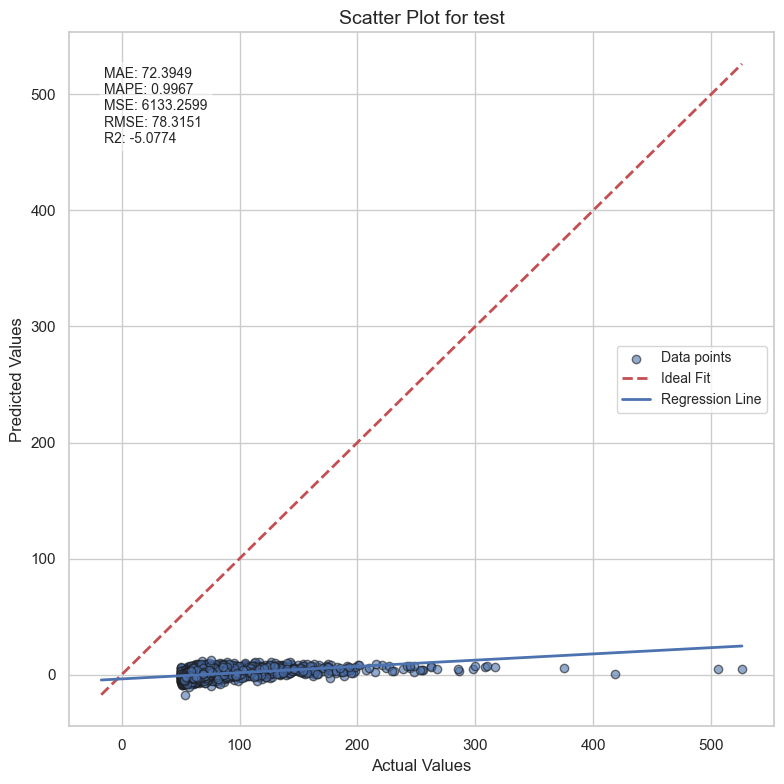

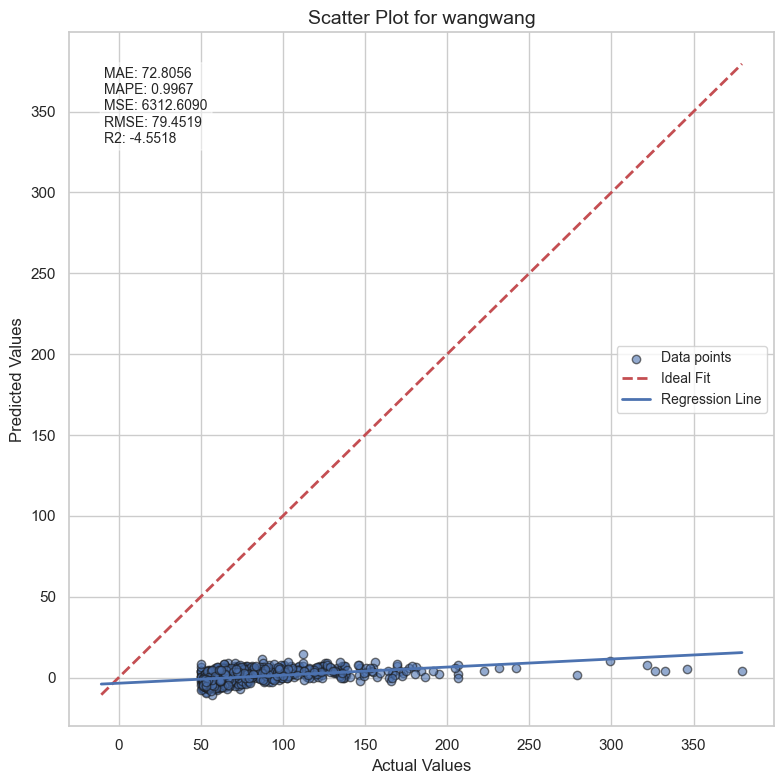

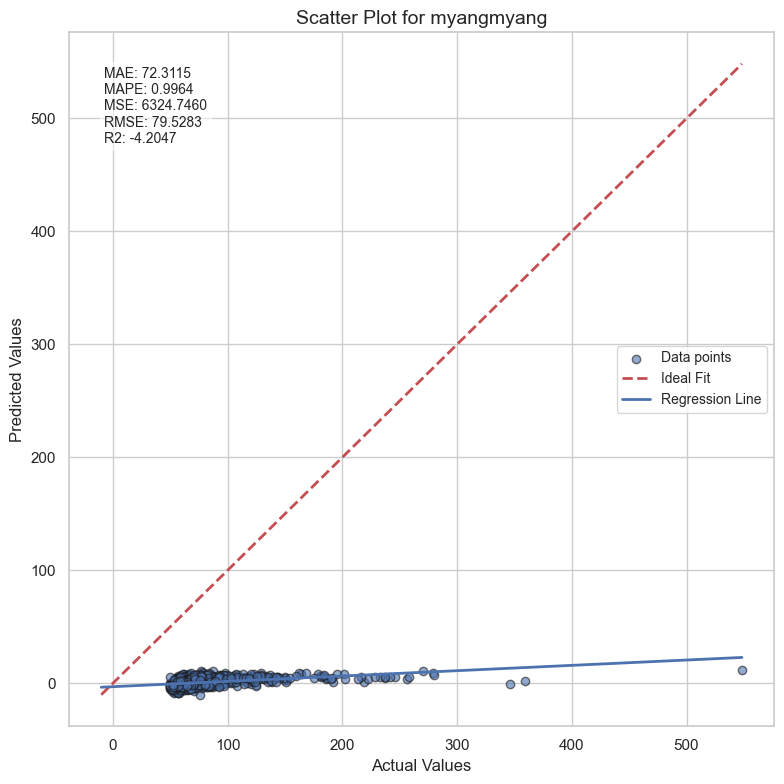

In [2]:
import platform
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim 
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from itertools import product
import random
import json
import datetime
import argparse

os_name = platform.system()

if os_name == "Windows":
    module_path = r"Y:/git/regression_model_tuning/src/"
    PATH = r"Y:/git/regression_model_tuning/test/"
else:
    module_path = r"/gpfs/home1/r1jae262/jupyter/git/regression_model_tuning/src/"
    PATH = r"/gpfs/home1/r1jae262/jupyter/git/regression_model_tuning/test/"

sys.path.insert(0, module_path)

from regression_model_tuning import Trainer

# 실험 설정 저장 경로
EXPERIMENT_DIR = os.path.join(PATH, "experiments")
RESULTS_FILE = os.path.join(EXPERIMENT_DIR, "results.json")
CHECKPOINT_FILE = os.path.join(EXPERIMENT_DIR, "checkpoint.json")
os.makedirs(EXPERIMENT_DIR, exist_ok=True)

# 실행할 시도 횟수 설정
MAX_TRIALS = 1  # 원하는 시도 횟수로 변경 가능

data_path = r"dataset/simulation_results.csv"
input_cols = [
    "N1","N2","N1_layer","N2_layer","per",
    "w1","l1","l2","l2_gap","h1","h1_gap","h2_gap",
    "N1_height_ratio","N1_fill_factor","N1_coil_diameter","N1_coil_zgap","N2_height_ratio","N2_fill_factor","N2_coil_diameter","N2_coil_zgap",
    "N1_space_w","N1_space_l","N2_space_w","N2_space_l","N1_layer_gap","N2_layer_gap","N1_offset_ratio","N2_offset_ratio","N1_offset","N2_offset",
    "cold_plate_x","cold_plate_y","cold_plate_z1","cold_plate_z2","mold_thick","thermal_conductivity"]
output_cols = ["Temp_max_core"]

T = Trainer(data_path=data_path, input_cols=input_cols, output_cols=output_cols, model_type="cnn")

T.data.drop_na()
T.data.outlier_filtering(outlier_constant=1.5)
T.data.split_data()
T.data.split_train_val_test(test_size=0.2, val_size=0.2, random_state=42)

# 하이퍼파라미터 그리드 정의
param_grid = {
    'learning_rate': [1e-5, 1e-4, 1e-3, 1e-2],
    'n_layers': [2, 3, 4, 5, 6], 
    'n_units': [32, 64, 96, 128, 192, 256],
    'dropout_rate': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5],
    'batch_size': [32, 64, 92, 128, 192, 256, 384, 512, 768, 1024],
    'epochs': [50, 100, 150, 200, 300, 500],
    'patience': [10, 20, 30, 40]
}

def train_model(params):
    model = T.model.build_model(
        input_dim=len(T.data.input_cols), 
        n_layers=params['n_layers'],
        n_units=params['n_units'], 
        activation="relu",
        dropout_rate=params['dropout_rate']
    )

    X_train_tensor, y_train_tensor = T.model.convert_data_to_tensor(T.data.train_X, T.data.train_Y, view_y=True)
    X_val_tensor, y_val_tensor = T.model.convert_data_to_tensor(T.data.val_X, T.data.val_Y, view_y=True)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = train_loader = DataLoader(
        train_dataset,
        batch_size=params['batch_size'],
        shuffle=True,
        num_workers=0,   # ⚠️ 반드시 0으로 설정
        pin_memory=True
    )


    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    criterion = nn.MSELoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=5)

    best_val_loss = np.inf
    patience_counter = 0
    epochs = params['epochs']

    for epoch in range(epochs):
        train_loss = T.model.train_one_epoch(model, optimizer, train_loader, T.model.device, criterion)
        val_loss = T.model.validate_epoch(model, X_val_tensor, y_val_tensor, T.model.device, criterion)
        
        scheduler.step(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= params['patience']:
            break

    model.load_state_dict(best_model_state)
    
    metrics_train, _ = T.model.evaluate_split(model, T.data.train_X, T.data.train_Y)
    metrics_val, _   = T.model.evaluate_split(model, T.data.val_X, T.data.val_Y)
    metrics_test, _  = T.model.evaluate_split(model, T.data.test_X, T.data.test_Y)

    return {
        'best_val_loss': float(best_val_loss),
        'metrics_train': {k: float(v) for k, v in metrics_train.items()},
        'metrics_val': {k: float(v) for k, v in metrics_val.items()},
        'metrics_test': {k: float(v) for k, v in metrics_test.items()},
        'model_state': best_model_state,
        'params': params
    }

# 체크포인트 로드 또는 초기화
if os.path.exists(CHECKPOINT_FILE):
    with open(CHECKPOINT_FILE, 'r') as f:
        checkpoint = json.load(f)
    results = checkpoint['results']
    completed_params = checkpoint['completed_params']
    current_trial = checkpoint['current_trial']
    print(f"체크포인트에서 {current_trial}/{MAX_TRIALS} 시도 복원")
else:
    current_trial = 0
    results = []
    completed_params = []
    
# 남은 하이퍼파라미터 조합 생성
all_combinations = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]
remaining_combinations = [p for p in all_combinations if p not in completed_params]
param_combinations = random.sample(remaining_combinations, min(MAX_TRIALS - current_trial, len(remaining_combinations)))

# 각 하이퍼파라미터 조합에 대해 학습 수행
for params in param_combinations:
    current_trial += 1
    print(f"시도 {current_trial}/{MAX_TRIALS}")
    print(f"\n시도하는 파라미터: {params}")
    
    try:
        result = train_model(params)
        results.append(result)
        completed_params.append(params)
        
        print(f"검증 손실: {result['best_val_loss']:.6f}")
        print(f"훈련 메트릭: {result['metrics_train']}")
        print(f"검증 메트릭: {result['metrics_val']}")
        print(f"테스트 메트릭: {result['metrics_test']}")
        
        # 체크포인트 저장
        checkpoint = {
            'results': results,
            'completed_params': completed_params,
            'current_trial': current_trial
        }
        with open(CHECKPOINT_FILE, 'w') as f:
            json.dump(checkpoint, f)
            
    except Exception as e:
        print(f"오류 발생: {e}")
        continue
        
    # 설정한 시도 횟수에 도달하면 중단
    if current_trial >= MAX_TRIALS:
        break

# 최고 성능 모델 찾기
best_result = min(results, key=lambda x: x['best_val_loss'])
print("\n최고 성능 모델:")
print(f"파라미터: {best_result['params']}")
print(f"최고 검증 손실: {best_result['best_val_loss']:.6f}")
print(f"최종 테스트 메트릭: {best_result['metrics_test']}")

# 최고 성능 모델 저장
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
model_dir = os.path.join(EXPERIMENT_DIR, "best_models", timestamp)
os.makedirs(model_dir, exist_ok=True)

torch.save({
    'model_state_dict': best_result['model_state'],
    'params': best_result['params'],
    'metrics': {
        'train': best_result['metrics_train'],
        'val': best_result['metrics_val'],
        'test': best_result['metrics_test']
    }
}, os.path.join(model_dir, 'best_model.pth'))

# 전체 실험 결과 저장
with open(RESULTS_FILE, 'w') as f:
    json.dump({
        'all_results': [
            {
                # model_state 제외
                k: v for k, v in r.items() if k != 'model_state'
            }
            for r in results
        ],
        'best_result': {
            'params': best_result['params'],
            'metrics': {
                'train': best_result['metrics_train'],
                'val': best_result['metrics_val'],
                'test': best_result['metrics_test'],
                'best_val_loss': best_result['best_val_loss']
            }
        }
    }, f, indent=2)

best_model = T.model.build_model(
    input_dim=len(T.data.input_cols),
    n_layers=best_result['params']['n_layers'],
    n_units=best_result['params']['n_units'],
    activation="relu", 
    dropout_rate=best_result['params']['dropout_rate']
)
best_model.load_state_dict(best_result['model_state'])
best_model.to(T.model.device)

T.model.plot_scatter(best_model, "test", T.data.train_X, T.data.train_Y, metrics=best_result['metrics_train'])
T.model.plot_scatter(best_model, "wangwang", T.data.val_X, T.data.val_Y, metrics=best_result['metrics_val'])
T.model.plot_scatter(best_model, "myangmyang", T.data.test_X, T.data.test_Y, metrics=best_result['metrics_test'])

In [ ]:
# best_result['model_state']는 OrderedDict이므로 모델 상태를 새 모델에 로드해야 함

# model.load_state_dict(best_result['model_state'])
best_model.eval()

X_tensor, _ = T.model.convert_data_to_tensor(T.data.train_X, T.data.train_Y, view_y=False)
y_pred = best_model(X_tensor)

y_pred

In [6]:
# 산점도 그래프를 그리고 표시하기 위해 plt.show() 추가
import matplotlib.pyplot as plt

T.model.plot_scatter(best_model, "test", T.data.train_X, T.data.train_Y, metrics=best_result['metrics_train'])
plt.show()

T.model.plot_scatter(best_model, "wangwang", T.data.val_X, T.data.val_Y, metrics=best_result['metrics_val']) 
plt.show()

T.model.plot_scatter(best_model, "myangmyang", T.data.test_X, T.data.test_Y, metrics=best_result['metrics_test'])
plt.show()